In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('prediction_train_with_targets.csv')
df = df.dropna()
df = df.drop(['id'], axis=1)

In [82]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = pd.read_csv('prediction_test_features.csv')

In [83]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()
test_features = test_features.drop(['id'], axis=1)

train_labels = train_features.pop('target_20')
test_labels = test_features

In [5]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
IV_30.0_-75.0_mean_50,0.244525,0.128169
IV_30.0_-50.0_sd_50,0.029592,0.024501
optionvolume_ratio_sd_10,3.559894,10.422610
put_call_OI_sd_25,0.253512,0.650495
adjclose_mean_10,78.762708,52.306745
...,...,...
optionOI_ratio_mean_25,1.004333,0.012481
IV_30.0_50.0_mean_50,0.227030,0.125859
open_close_sd_25,0.011283,0.008087
high_close_mean_5,1.008660,0.013089


In [6]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

In [20]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(176, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [21]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 176)               353       
_________________________________________________________________
dense_1 (Dense)              (None, 176)               31152     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                11328     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 42,898
Trainable params: 42,545
Non-trainable params: 353
_________________________________________________________________


In [22]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=200)

CPU times: user 3min 25s, sys: 28.2 s, total: 3min 53s
Wall time: 1min 48s


In [23]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

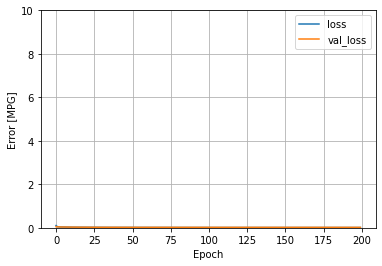

In [24]:
plot_loss(history)

In [25]:
test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [26]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
dnn_model,0.021133


In [84]:
test_predictions = dnn_model.predict(test_features).flatten()

In [85]:
print(test_dataset.shape)
print(test_predictions.shape)

(27881, 177)
(27881,)


In [86]:
test_dataset["prediction"] = test_predictions
test_dataset['prediction'].loc[(test_dataset['prediction'] > 0)] = 1
test_dataset['prediction'].loc[(test_dataset['prediction'] < 0)] = -1
test_dataset

/home/alex/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/alex/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,IV_30.0_-75.0_mean_50,IV_30.0_-50.0_sd_50,optionvolume_ratio_sd_10,put_call_OI_sd_25,adjclose_mean_10,IV_30.0_-75.0,high_close_mean_50,logreturn_sd_50,optionvolume_ratio_sd_5,adjclose_mean_5,...,IV_30.0_75.0_mean_10,dollarvolume_ratio_mean_50,low_close_mean_25,low_close_mean_10,put_call_OI_sd_100,optionOI_ratio_mean_25,IV_30.0_50.0_mean_50,open_close_sd_25,high_close_mean_5,prediction
0,0.409024,0.040958,1.442129,0.189349,87.246591,0.346684,1.014164,0.024411,1.330456,88.699363,...,0.464682,1.101507,0.983345,0.984698,0.152594,1.094560,0.422942,0.021365,1.006051,-1.0
1,0.520618,0.215150,2.916665,0.056903,50.590069,0.495967,1.023061,0.051954,2.934390,53.667975,...,0.678095,1.104032,0.966775,0.976784,0.611394,0.998366,0.555276,0.029633,1.005482,-1.0
2,0.424938,0.057386,0.257855,0.018873,96.700848,0.454241,1.014433,0.025387,0.297858,96.358263,...,0.517371,1.079214,0.978892,0.979678,0.128329,1.004879,0.442027,0.022147,1.014317,-1.0
3,0.410953,0.039563,0.835214,0.126142,91.203440,0.367739,1.014215,0.025020,1.128700,93.257875,...,0.439835,1.080893,0.986441,0.988335,0.143375,1.021802,0.425151,0.018708,1.009752,1.0
4,0.409093,0.041097,0.974374,0.175269,88.924184,0.376801,1.014966,0.025012,0.420373,89.149005,...,0.448983,1.080000,0.984571,0.986245,0.150113,1.083310,0.423922,0.021329,1.017976,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27876,0.117887,0.021468,1.187967,0.349588,160.265803,0.121321,1.004100,0.007882,0.678865,161.517390,...,0.151211,1.086356,0.996083,0.997200,0.398485,1.008625,0.136414,0.004739,1.004411,1.0
27877,0.133866,0.014299,0.995753,0.176657,120.012743,0.074644,1.002536,0.004269,0.959380,119.996731,...,0.121350,1.105157,0.996424,0.996805,0.208692,1.003714,0.095766,0.002344,1.002089,-1.0
27878,0.123361,0.023687,0.829702,0.127749,173.184658,0.098138,1.003353,0.006299,0.323857,173.805530,...,0.133085,1.145244,0.996434,0.996635,0.820789,1.008327,0.125380,0.002536,1.000944,1.0
27879,0.111712,0.023071,0.900048,0.026851,149.308411,0.077750,1.003543,0.006153,0.586200,148.807846,...,0.131477,1.121136,0.996093,0.996934,0.034759,1.008978,0.116807,0.004100,1.002764,1.0


In [88]:
test_prediction_final = pd.DataFrame([test_dataset['prediction']])
test_prediction_final = test_prediction_final.T
test_prediction_final

,prediction
0,-1.0
1,-1.0
2,-1.0
3,1.0
4,-1.0
...,...
27876,1.0
27877,-1.0
27878,1.0
27879,1.0


In [89]:
test_prediction_final.to_csv('qcap_test_prediction.csv')